<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-S10/blob/master/S10_Trial5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

**<h2>Install Albumentations and Apex librabies</h2>**

In [2]:
!pip install -U git+https://github.com/albu/albumentations
!pip install --no-cache-dir git+https://github.com/NVIDIA/apex

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-7qjoc84w
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-7qjoc84w
     |████████████████████████████████| 634kB 7.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65100 sha256=07ec2457f13b4c1e345ec64aaafb518510938a297278048615a4e31762bd2637
  Stored in directory: /tmp/pip-ephem-wheel-cache-t8qm2s9m/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=f05c22daab827243453df94f44745ca328cef08366ad9e972511925694e7ef8a
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  

In [3]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/Session10'
sys.path.append(folder)

In [0]:
import torch
import Albumentation
import show_images
import my_model
import train_test
import evaluate
import GradCam
import lr_finder

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [6]:
classes, trainloader, testloader = Albumentation.album_Compose.load()

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



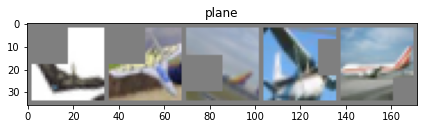

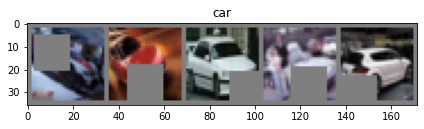

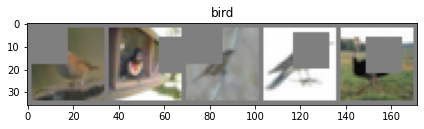

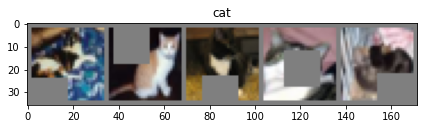

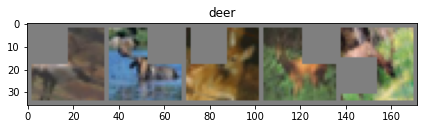

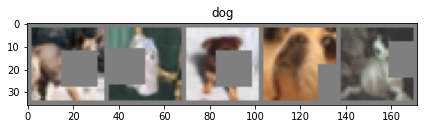

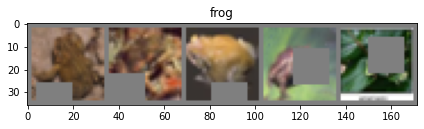

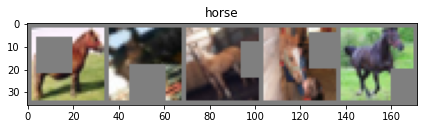

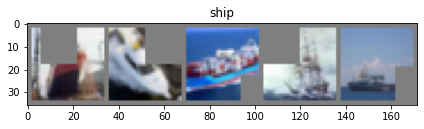

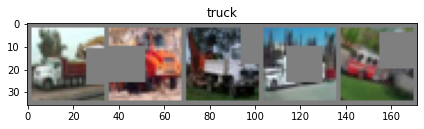

In [7]:
show_images.show_random_images(trainloader, classes)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
resnet = my_model.ResNet18().to(device)
summary(resnet, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [12]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(resnet.parameters(), lr=0.00001,momentum=0.9 ,weight_decay = 0.0001)
lrfinder = lr_finder.LRFinder(resnet, optimiser, criterion, device="cuda")
lrfinder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=600 ,step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


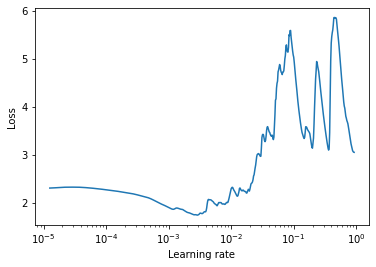

In [13]:
lrfinder.plot()

In [14]:
Best_lr = lrfinder.history['lr'][lrfinder.history['loss'].index(lrfinder.best_loss)]
print(Best_lr)

0.0028729848333536637


In [0]:
lrfinder.reset()

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, patience = 3,min_lr=1e-4)

In [17]:
train_loss=[]
train_acc=[]
EPOCHS = 50

for epoch in range(EPOCHS):
      print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
      train_loss, train_acc = train_test.train(resnet, device, trainloader, optimizer, criterion, epoch)
      test_loss , test_acc = train_test.test(resnet, device, criterion, testloader)
      scheduler.step(test_loss[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.0028729848333536637


Loss=1.3163716793060303 Batch_id=390 Accuracy=42.07: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 5176/10000 (51.76%)

EPOCH: 2 LR: 0.0028729848333536637


Loss=1.1915185451507568 Batch_id=390 Accuracy=56.51: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 6264/10000 (62.64%)

EPOCH: 3 LR: 0.0028729848333536637


Loss=1.0183840990066528 Batch_id=390 Accuracy=63.15: 100%|██████████| 391/391 [00:32<00:00, 11.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 6659/10000 (66.59%)

EPOCH: 4 LR: 0.0028729848333536637


Loss=0.9001277685165405 Batch_id=390 Accuracy=67.45: 100%|██████████| 391/391 [00:33<00:00, 11.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 7214/10000 (72.14%)

EPOCH: 5 LR: 0.0028729848333536637


Loss=0.7471987009048462 Batch_id=390 Accuracy=70.20: 100%|██████████| 391/391 [00:32<00:00, 11.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7511/10000 (75.11%)

EPOCH: 6 LR: 0.0028729848333536637


Loss=0.7327117323875427 Batch_id=390 Accuracy=72.61: 100%|██████████| 391/391 [00:33<00:00, 11.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7890/10000 (78.90%)

EPOCH: 7 LR: 0.0028729848333536637


Loss=0.9306103587150574 Batch_id=390 Accuracy=74.26: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8000/10000 (80.00%)

EPOCH: 8 LR: 0.0028729848333536637


Loss=0.6914831399917603 Batch_id=390 Accuracy=75.96: 100%|██████████| 391/391 [00:33<00:00, 11.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7857/10000 (78.57%)

EPOCH: 9 LR: 0.0028729848333536637


Loss=0.888580322265625 Batch_id=390 Accuracy=77.05: 100%|██████████| 391/391 [00:33<00:00, 11.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7955/10000 (79.55%)

EPOCH: 10 LR: 0.0028729848333536637


Loss=0.6351052522659302 Batch_id=390 Accuracy=78.10: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8111/10000 (81.11%)

EPOCH: 11 LR: 0.0028729848333536637


Loss=0.5852092504501343 Batch_id=390 Accuracy=78.95: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8295/10000 (82.95%)

EPOCH: 12 LR: 0.0028729848333536637


Loss=0.5827757120132446 Batch_id=390 Accuracy=79.90: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8416/10000 (84.16%)

EPOCH: 13 LR: 0.0028729848333536637


Loss=0.63569575548172 Batch_id=390 Accuracy=80.67: 100%|██████████| 391/391 [00:33<00:00, 11.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8408/10000 (84.08%)

EPOCH: 14 LR: 0.0028729848333536637


Loss=0.4195442795753479 Batch_id=390 Accuracy=81.54: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8459/10000 (84.59%)

EPOCH: 15 LR: 0.0028729848333536637


Loss=0.6387186050415039 Batch_id=390 Accuracy=82.06: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8247/10000 (82.47%)

EPOCH: 16 LR: 0.0028729848333536637


Loss=0.2982749342918396 Batch_id=390 Accuracy=82.80: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8527/10000 (85.27%)

EPOCH: 17 LR: 0.0028729848333536637


Loss=0.598328709602356 Batch_id=390 Accuracy=83.17: 100%|██████████| 391/391 [00:32<00:00, 11.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8263/10000 (82.63%)

EPOCH: 18 LR: 0.0028729848333536637


Loss=0.6746917963027954 Batch_id=390 Accuracy=83.83: 100%|██████████| 391/391 [00:32<00:00, 11.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8562/10000 (85.62%)

EPOCH: 19 LR: 0.0028729848333536637


Loss=0.35137954354286194 Batch_id=390 Accuracy=84.30: 100%|██████████| 391/391 [00:32<00:00, 11.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8287/10000 (82.87%)

EPOCH: 20 LR: 0.0028729848333536637


Loss=0.6208874583244324 Batch_id=390 Accuracy=84.59: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8620/10000 (86.20%)

EPOCH: 21 LR: 0.0028729848333536637


Loss=0.3060314953327179 Batch_id=390 Accuracy=85.17: 100%|██████████| 391/391 [00:32<00:00, 11.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8755/10000 (87.55%)

EPOCH: 22 LR: 0.0028729848333536637


Loss=0.5130738019943237 Batch_id=390 Accuracy=85.68: 100%|██████████| 391/391 [00:32<00:00, 11.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8750/10000 (87.50%)

EPOCH: 23 LR: 0.0028729848333536637


Loss=0.2848237454891205 Batch_id=390 Accuracy=86.09: 100%|██████████| 391/391 [00:32<00:00, 11.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8635/10000 (86.35%)

EPOCH: 24 LR: 0.0028729848333536637


Loss=0.4343028962612152 Batch_id=390 Accuracy=86.31: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8623/10000 (86.23%)

EPOCH: 25 LR: 0.0028729848333536637


Loss=0.2879003882408142 Batch_id=390 Accuracy=86.66: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8773/10000 (87.73%)

EPOCH: 26 LR: 0.00028729848333536637


Loss=0.25042057037353516 Batch_id=390 Accuracy=89.31: 100%|██████████| 391/391 [00:33<00:00, 11.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8989/10000 (89.89%)

EPOCH: 27 LR: 0.00028729848333536637


Loss=0.36661985516548157 Batch_id=390 Accuracy=90.33: 100%|██████████| 391/391 [00:33<00:00, 11.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9028/10000 (90.28%)

EPOCH: 28 LR: 0.00028729848333536637


Loss=0.3110129237174988 Batch_id=390 Accuracy=90.64: 100%|██████████| 391/391 [00:33<00:00, 11.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9023/10000 (90.23%)

EPOCH: 29 LR: 0.00028729848333536637


Loss=0.32814091444015503 Batch_id=390 Accuracy=90.82: 100%|██████████| 391/391 [00:33<00:00, 11.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9033/10000 (90.33%)

EPOCH: 30 LR: 0.00028729848333536637


Loss=0.23405225574970245 Batch_id=390 Accuracy=90.97: 100%|██████████| 391/391 [00:33<00:00, 11.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9031/10000 (90.31%)

EPOCH: 31 LR: 0.00028729848333536637


Loss=0.2958122193813324 Batch_id=390 Accuracy=91.00: 100%|██████████| 391/391 [00:33<00:00, 11.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9062/10000 (90.62%)

EPOCH: 32 LR: 0.00028729848333536637


Loss=0.24023480713367462 Batch_id=390 Accuracy=91.25: 100%|██████████| 391/391 [00:33<00:00, 11.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9067/10000 (90.67%)

EPOCH: 33 LR: 0.00028729848333536637


Loss=0.30340057611465454 Batch_id=390 Accuracy=91.35: 100%|██████████| 391/391 [00:33<00:00, 11.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9054/10000 (90.54%)

EPOCH: 34 LR: 0.00028729848333536637


Loss=0.2944679856300354 Batch_id=390 Accuracy=91.57: 100%|██████████| 391/391 [00:33<00:00, 11.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9064/10000 (90.64%)

EPOCH: 35 LR: 0.00028729848333536637


Loss=0.23901128768920898 Batch_id=390 Accuracy=91.53: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9068/10000 (90.68%)

EPOCH: 36 LR: 0.00028729848333536637


Loss=0.30677375197410583 Batch_id=390 Accuracy=91.67: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9053/10000 (90.53%)

EPOCH: 37 LR: 0.00028729848333536637


Loss=0.26356983184814453 Batch_id=390 Accuracy=91.78: 100%|██████████| 391/391 [00:33<00:00, 11.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9068/10000 (90.68%)

EPOCH: 38 LR: 0.00028729848333536637


Loss=0.2466680109500885 Batch_id=390 Accuracy=91.84: 100%|██████████| 391/391 [00:32<00:00, 11.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9068/10000 (90.68%)

EPOCH: 39 LR: 0.00028729848333536637


Loss=0.27436932921409607 Batch_id=390 Accuracy=92.01: 100%|██████████| 391/391 [00:32<00:00, 11.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9093/10000 (90.93%)

EPOCH: 40 LR: 0.00028729848333536637


Loss=0.31981098651885986 Batch_id=390 Accuracy=92.16: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9083/10000 (90.83%)

EPOCH: 41 LR: 0.00028729848333536637


Loss=0.22707049548625946 Batch_id=390 Accuracy=92.00: 100%|██████████| 391/391 [00:32<00:00, 11.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9091/10000 (90.91%)

EPOCH: 42 LR: 0.00028729848333536637


Loss=0.2371830940246582 Batch_id=390 Accuracy=92.24: 100%|██████████| 391/391 [00:32<00:00, 11.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9104/10000 (91.04%)

EPOCH: 43 LR: 0.00028729848333536637


Loss=0.2124040573835373 Batch_id=390 Accuracy=92.11: 100%|██████████| 391/391 [00:32<00:00, 11.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9085/10000 (90.85%)

EPOCH: 44 LR: 0.00028729848333536637


Loss=0.1979202926158905 Batch_id=390 Accuracy=92.46: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9074/10000 (90.74%)

EPOCH: 45 LR: 0.00028729848333536637


Loss=0.2514054477214813 Batch_id=390 Accuracy=92.58: 100%|██████████| 391/391 [00:32<00:00, 11.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9092/10000 (90.92%)

EPOCH: 46 LR: 0.00028729848333536637


Loss=0.3679438531398773 Batch_id=390 Accuracy=92.40: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9094/10000 (90.94%)

EPOCH: 47 LR: 0.0001


Loss=0.23920473456382751 Batch_id=390 Accuracy=92.73: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9097/10000 (90.97%)

EPOCH: 48 LR: 0.0001


Loss=0.2672303020954132 Batch_id=390 Accuracy=92.92: 100%|██████████| 391/391 [00:33<00:00, 11.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9097/10000 (90.97%)

EPOCH: 49 LR: 0.0001


Loss=0.17756618559360504 Batch_id=390 Accuracy=92.76: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9096/10000 (90.96%)

EPOCH: 50 LR: 0.0001


Loss=0.15277084708213806 Batch_id=390 Accuracy=92.94: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]



Test set: Average loss: 0.0022, Accuracy: 9097/10000 (90.97%)



In [18]:
evaluate.evaluate_accuracy(resnet, device, testloader)

Accuracy of the network on the 10000 test images: 90.970 %


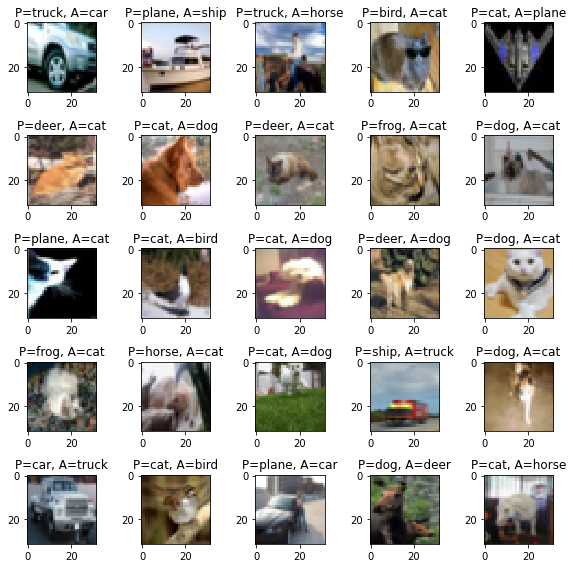

In [19]:
misclassified_images = evaluate.show_misclassified_images(resnet, device, testloader, classes)

In [20]:
evaluate.evaluate_classwise_accuracy(resnet, device, classes, testloader)

Accuracy of plane : 94 %
Accuracy of   car : 100 %
Accuracy of  bird : 87 %
Accuracy of   cat : 80 %
Accuracy of  deer : 96 %
Accuracy of   dog : 81 %
Accuracy of  frog : 86 %
Accuracy of horse : 97 %
Accuracy of  ship : 100 %
Accuracy of truck : 92 %


Text(0.5, 1.0, 'Accuracy Change')

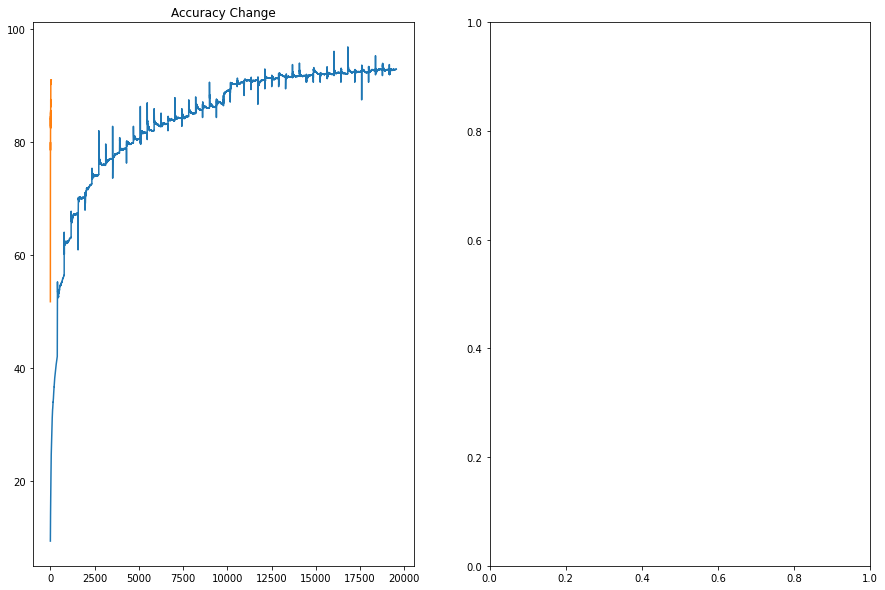

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(15,10))

axs[0].plot(train_acc)
axs[0].plot(test_acc)
axs[0].set_title("Accuracy Change")

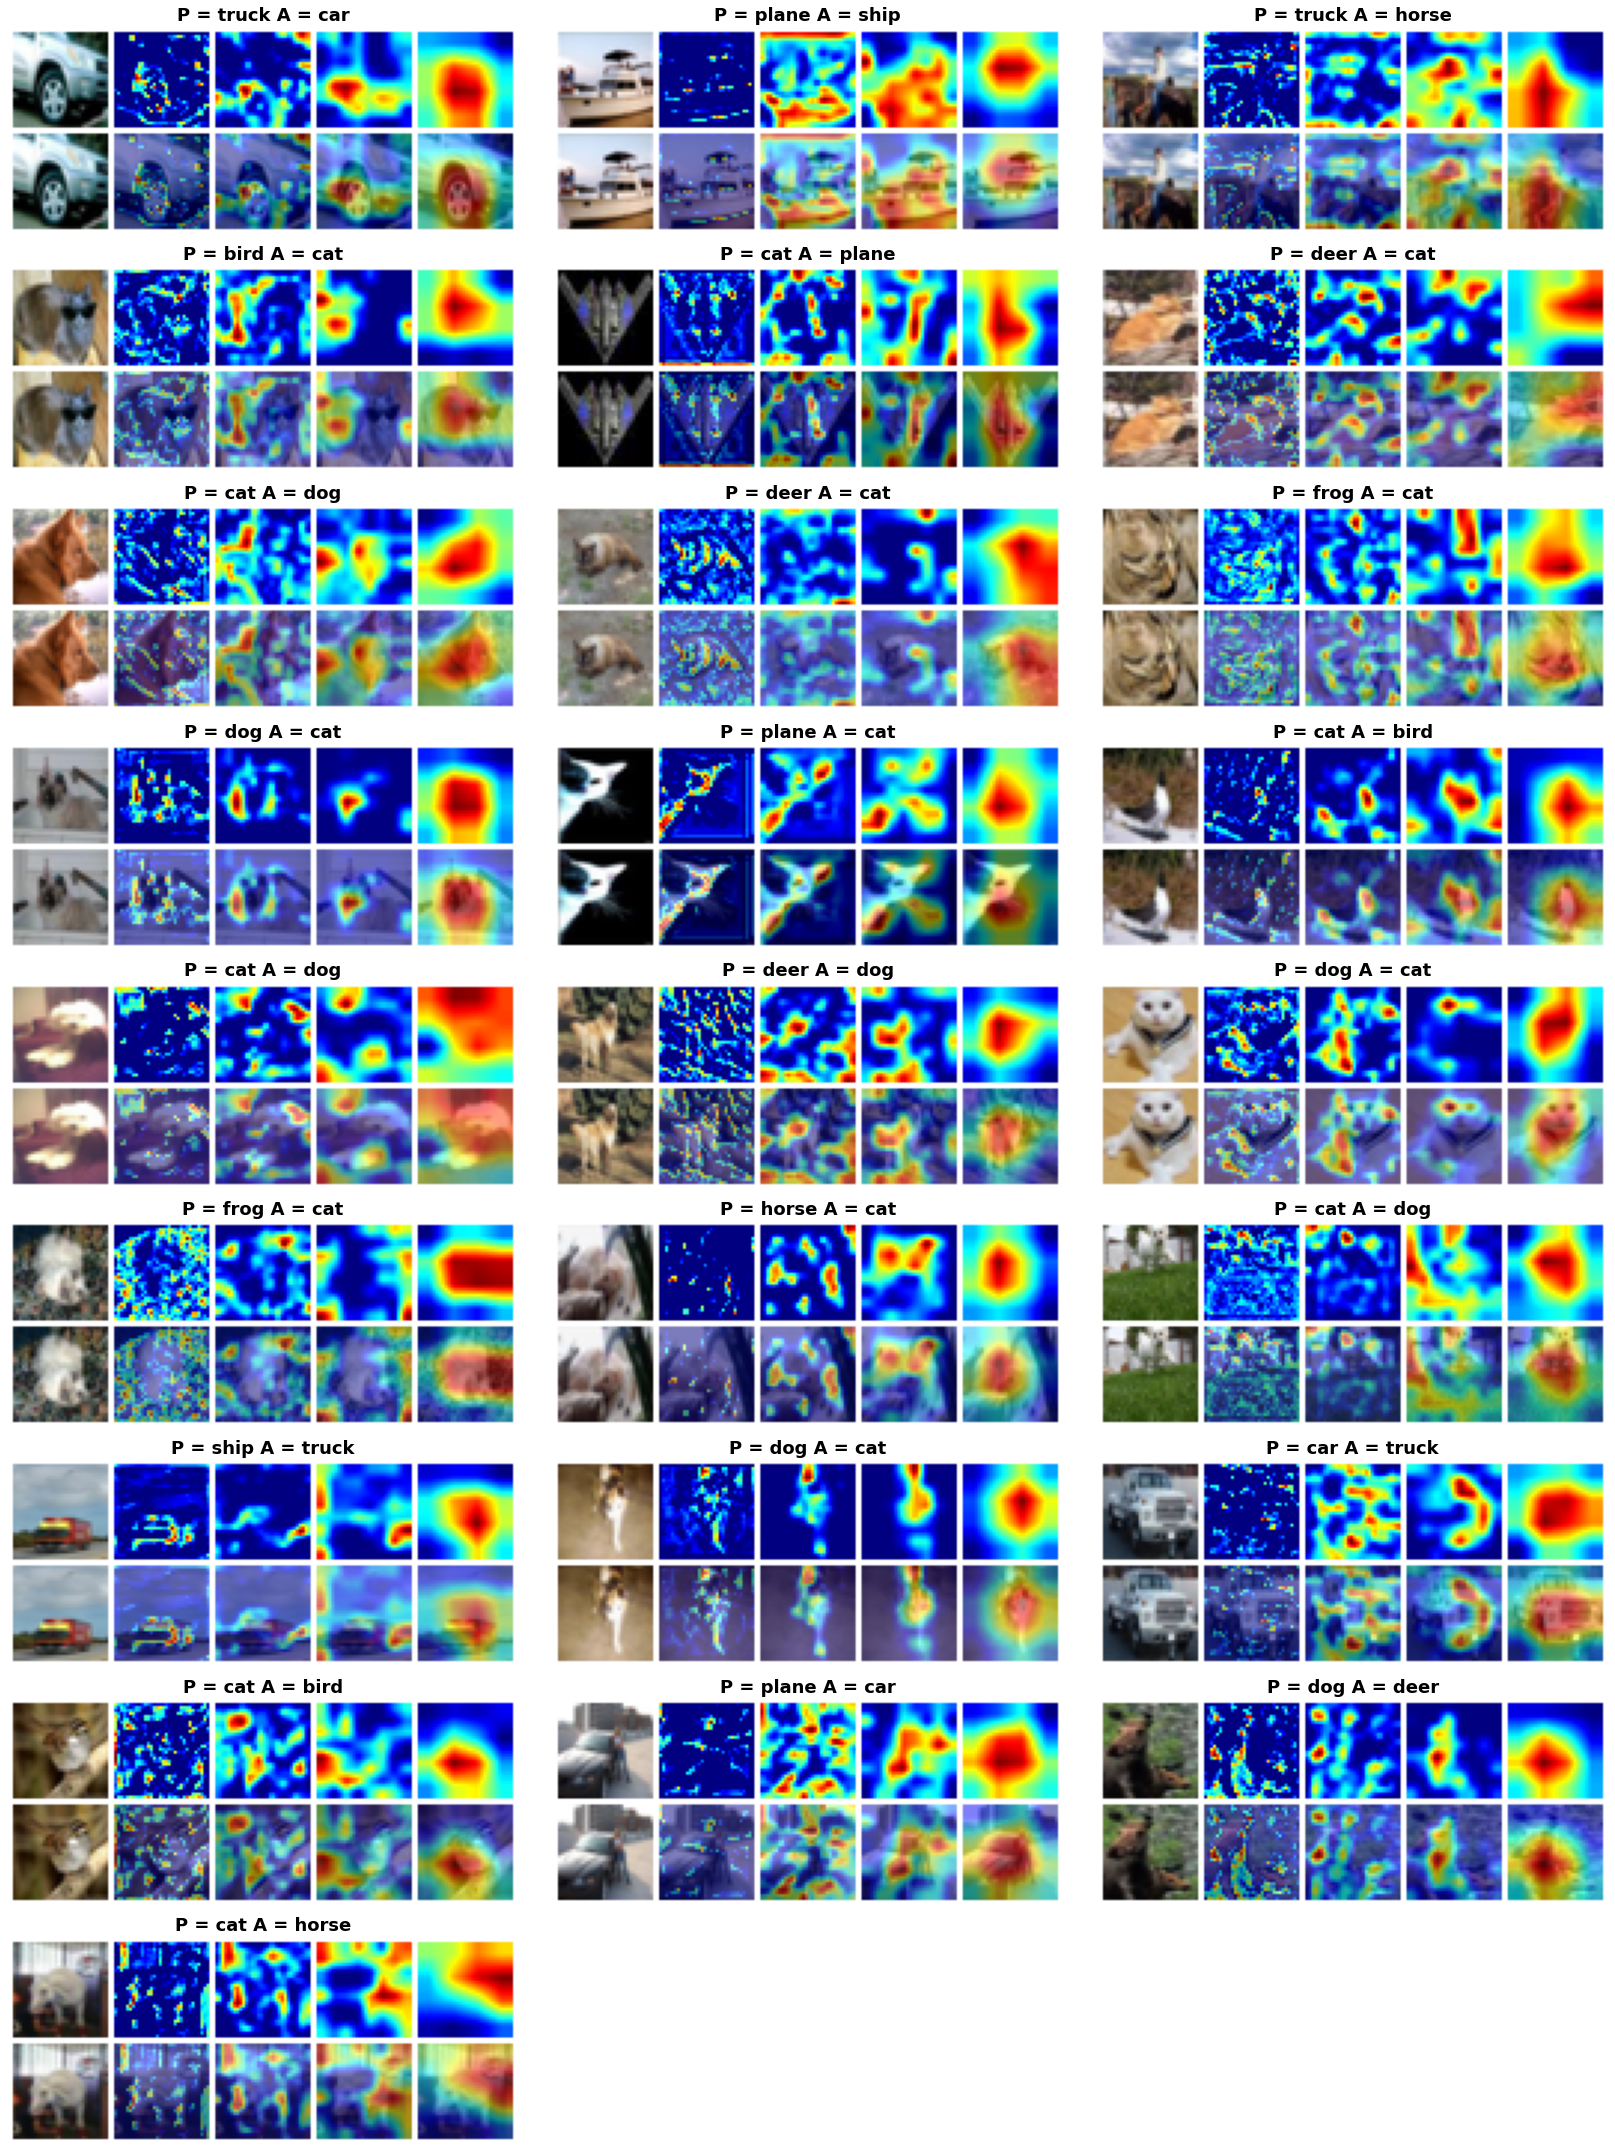

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from torchvision.utils import make_grid, save_image
fig = plt.figure(figsize=(23,30))
for i,k in enumerate(misclassified_images):
  images1 = [misclassified_images[i][0].cpu()/2+0.5]
  images2 =  [misclassified_images[i][0].cpu()/2+0.5]
  b = resnet.to(device)
  # output = model(misclassified_images[i][0])
  # _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [resnet.layer1,resnet.layer2,resnet.layer3,resnet.layer4]
  for j in layers:
    g = GradCam.GradCAM(b,j)
    mask, _= g(misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = GradCam.GradCAM.visualize_cam(mask,misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5,pad_value=1)
  npimg = grid_image.numpy()
  sub = fig.add_subplot(9, 3, i+1) 
 
  # fig.subplots_adjust(wspace=0)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  sub.set_title('P = '+classes[int(misclassified_images[i][1])]+" A = "+classes[int(misclassified_images[i][2])],fontweight="bold",fontsize=18)
  sub.axis("off")
plt.tight_layout()
fig.subplots_adjust(wspace=0)